# Polarisation and the perimeter elasticity model

The relevant model is described in [Mapeng Bi et al.](https://arxiv.org/abs/1409.0593v4) (
[nature physics version](https://www.nature.com/articles/nphys3471))

The master equation is the following:

$$\epsilon = \sum_\alpha \left[ (a_\alpha - 1)^2 + \frac{(p_\alpha - p_0)^2}{r}\right]$$

With a unit prefered area and $p_\alpha$ the cell perimeter. This model has the advantage of providing 

Here, we modify this equation by modulating the contribution of each junction of a cell to account for polarity, such that:

$$ p_\alpha =  \frac{\sum_{ij \in \alpha} w_{ij}\ell_{ij}}{\sum_{ij \in \alpha} w_{ij}}n_{ij} $$

### Imports

In [1]:
import numpy as np
import pandas as pd

from tyssue import config, Sheet, PlanarGeometry
from tyssue.solvers import QSSolver

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw import sheet_view

from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import effectors, units
from tyssue.utils import to_nd
from tyssue.utils.testing import effector_tester, model_tester
from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import basic_events

from tyssue.draw import highlight_faces, create_gif
from polarity.dynamics import PerimeterElasticity
import matplotlib.pyplot as plt
%matplotlib inline

### Create a 2D patch of cells

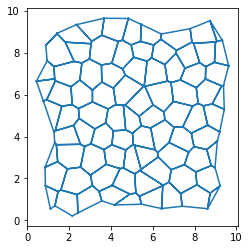

In [2]:
base_geom = PlanarGeometry

sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
base_geom.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 10], [0, 10]]), trim_borders=True)
sheet.sanitize()
base_geom.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
base_geom.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
sheet.edge_df["weighted"] = 1
sheet.face_df['prefered_area']=sheet.face_df.area
sheet.face_df['prefered_perimeter'] = 2.*np.sqrt(sheet.face_df['prefered_area'])
sheet.face_df['perimeter_elasticity'] = 10.
sheet.face_df['area_elasticity'] = 1.

fig, ax = sheet_view(sheet, mode="quick")

In [3]:
class WPGeometry(base_geom):
    
    @classmethod
    def update_all(cls, sheet):
        base_geom.update_all(sheet)
        cls.update_perimeters(sheet)
    
    @staticmethod
    def update_perimeters(sheet):
        weighted_lengths = sheet.edge_df.eval("weighted * length")
        sheet.face_df['perimeter'] = sheet.sum_face(weighted_lengths)
        
    
    @staticmethod
    def normalize_weights(sheet):
        sheet.edge_df["num_sides"] = sheet.upcast_face('num_sides')
        sheet.edge_df["weight"] = sheet.edge_df.groupby('face').apply(
            lambda df: (df["num_sides"] * df["weighted"]
                        / df["weighted"].sum())
        ).sort_index(level='edge').to_numpy()
        
geom = WPGeometry

### Quasistatic gradient descent

With only the conservative potential terms

In [4]:

model = model_factory(
    [PerimeterElasticity,
     effectors.FaceAreaElasticity,
    ],
     effectors.FaceAreaElasticity)

res = QSSolver().find_energy_min(sheet, geom, model)

print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Backup so we can play with parameters

In [5]:
bck = sheet.copy()

## Pulling on a face

Chosen with trial and error

#### Simple visualisation

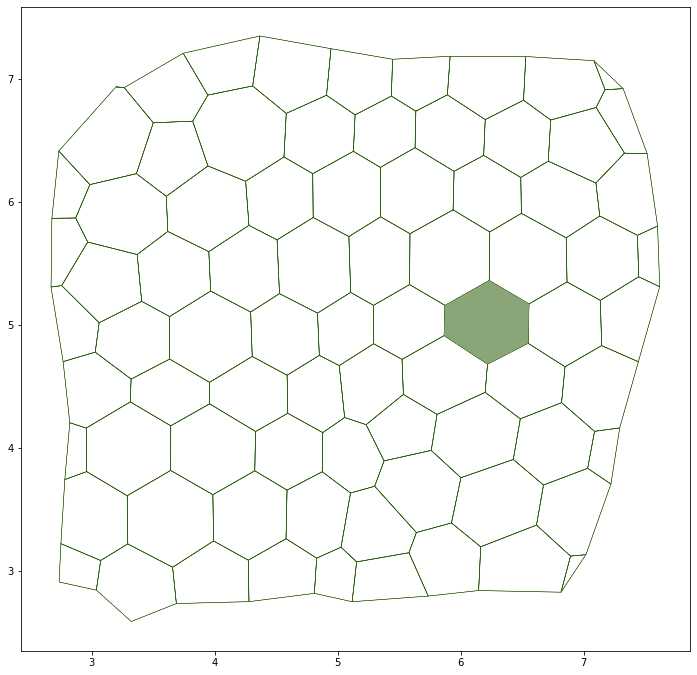

In [6]:
highlight_faces(sheet.face_df, [40], reset_visible=True)
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={"head_width": 0.0},
    vert={"visible": False})
fig.set_size_inches(12, 12)

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


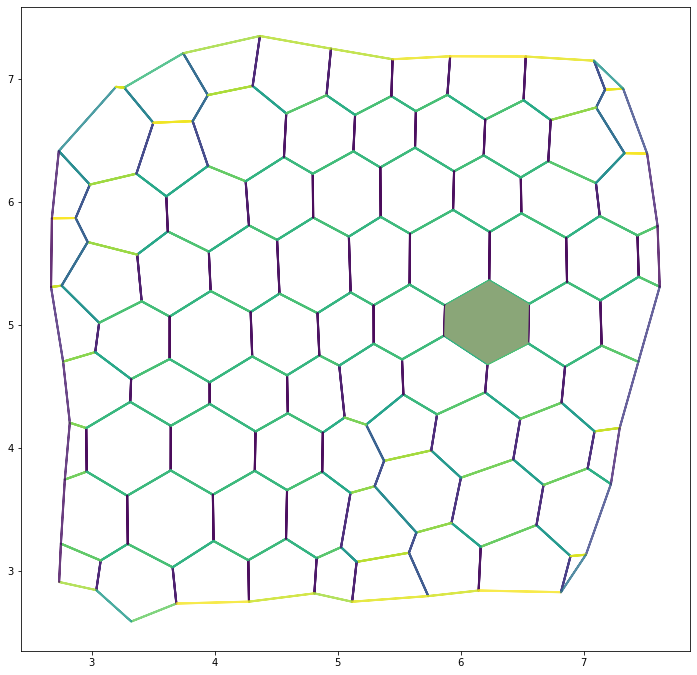

In [7]:
thetas = np.arctan(sheet.edge_df.dx/sheet.edge_df.dy)
sheet.edge_df['weighted'] = 1 + np.abs(thetas) / np.pi
geom.normalize_weights(sheet)
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={"head_width": 0.0, "width": 2.0, "color": sheet.edge_df['weighted']}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)

In [8]:
res = QSSolver().find_energy_min(sheet, geom, model)

print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


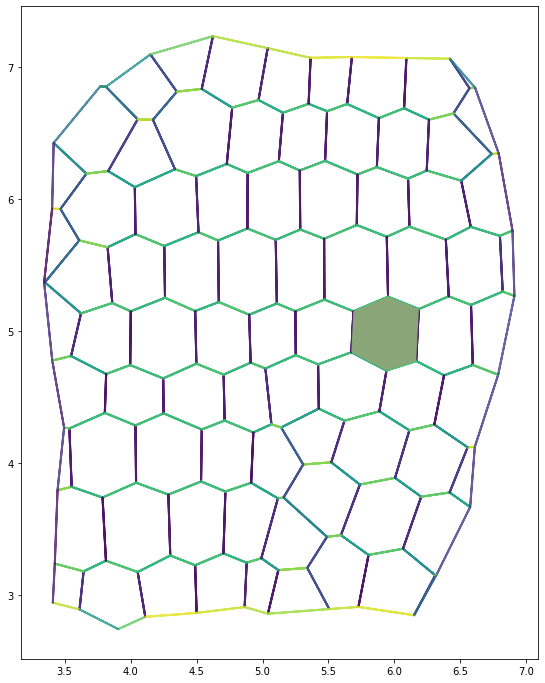

In [9]:
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={
        "head_width": 0.0,
        "width": 2.0,
        "color": sheet.edge_df['weight']}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)

(array([ 1.,  2.,  4.,  2.,  4., 10., 27., 16.,  8.,  6.]),
 array([0.00348663, 0.09925969, 0.19503276, 0.29080582, 0.38657889,
        0.48235195, 0.57812502, 0.67389809, 0.76967115, 0.86544422,
        0.96121728]),
 <a list of 10 Patch objects>)

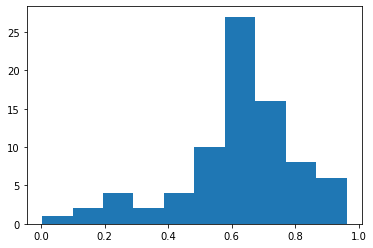

In [37]:
plt.hist(sheet.face_df['prefered_area']-sheet.face_df.area)

(array([ 4.,  5.,  6.,  9., 20., 19.,  9.,  5.,  2.,  1.]),
 array([0.0021232 , 0.00401466, 0.00590613, 0.00779759, 0.00968905,
        0.01158051, 0.01347197, 0.01536344, 0.0172549 , 0.01914636,
        0.02103782]),
 <a list of 10 Patch objects>)

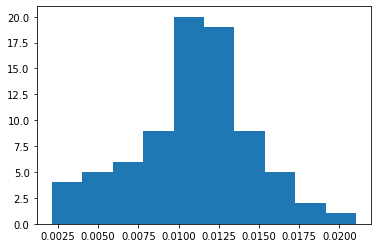

In [38]:
plt.hist(np.abs(sheet.face_df['prefered_perimeter']-sheet.face_df.perimeter))

(array([78.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  4.45227023,  19.89405522,  35.3358402 ,  50.77762518,
         66.21941016,  81.66119514,  97.10298012, 112.5447651 ,
        127.98655008, 143.42833506, 158.87012005]),
 <a list of 10 Patch objects>)

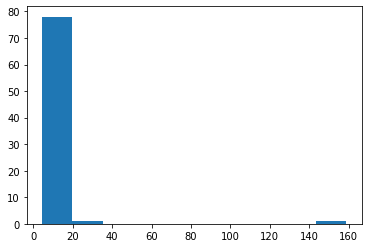

In [39]:
plt.hist(sheet.face_df.perimeter/np.sqrt(sheet.face_df.area))

In [13]:
sheet.face_df.loc[40,['prefered_area', 'area', 'prefered_perimeter','perimeter']]

prefered_area          1.12783
area                  0.224819
prefered_perimeter     2.12399
perimeter              2.14071
Name: 40, dtype: object

In [33]:
sheet.face_df.loc[40,'prefered_area'] /= 1.08
sheet.face_df.loc[40,'prefered_perimeter'] /= np.sqrt(1.08)

In [34]:
sheet.face_df.loc[40,['prefered_area', 'area', 'prefered_perimeter','perimeter']]

prefered_area         0.483707
area                   0.17939
prefered_perimeter     1.39098
perimeter              1.90457
Name: 40, dtype: object

In [35]:
res = QSSolver().find_energy_min(sheet, geom, model)
sheet.face_df.loc[40,['prefered_area', 'area', 'prefered_perimeter','perimeter']]

prefered_area          0.483707
area                  0.0970773
prefered_perimeter      1.39098
perimeter                1.3991
Name: 40, dtype: object

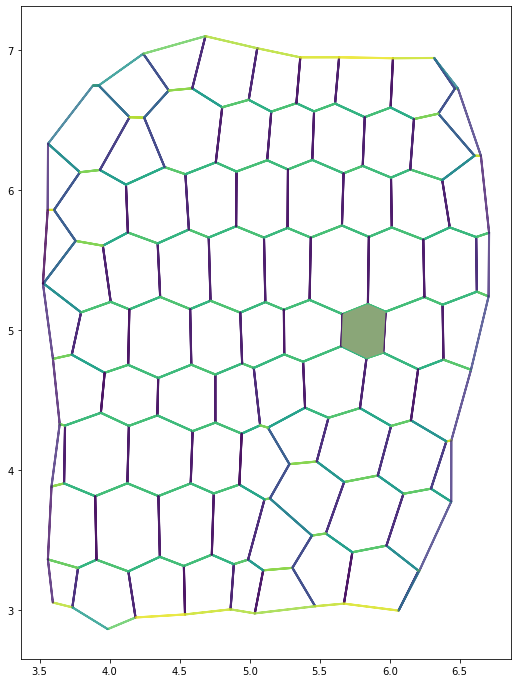

In [36]:
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={
        "head_width": 0.0,
        "width": 2.0,
        "color": sheet.edge_df['weight']}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)